In [2]:
# Install Dependencies
!pip install transformers scikit-learn

In [3]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import re
from sklearn.model_selection import train_test_split

# Enable CUDA Debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load Dataset and Preprocess
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url)

# Keep only relevant columns
df = df[['tweet', 'class']]
df = df[df['class'].isin([0, 1, 2])]  # Ensure labels are in range [0, 1, 2]

# Text Preprocessing: Normalize text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return text

df['tweet'] = df['tweet'].apply(preprocess_text)

# Use the entire dataset
texts = df['tweet'].values
labels = df['class'].values

# Compute class weights for bias mitigation
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare Dataset
dataset = HateSpeechDataset(texts, labels, tokenizer)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Configure and Load DistilBERT
model_bert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir='./logs',
    report_to="none",
    fp16=True  # Enable mixed precision for faster GPU training
)

# Evaluation Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Train and Evaluate DistilBERT
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Training DistilBERT...")
trainer.train()
results_bert = trainer.evaluate()
print(f"DistilBERT Results: {results_bert}")

# Precompute DistilBERT Embeddings
def precompute_embeddings(dataset, model, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=32)
    embeddings, labels = [], []
    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key in ['input_ids', 'attention_mask']}
            labels.append(batch['label'].cpu())
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]
            embeddings.append(hidden_states.mean(dim=1).cpu())

    return torch.cat(embeddings), torch.cat(labels)

print("Precomputing DistilBERT embeddings...")
bert_embeddings, test_labels = precompute_embeddings(test_dataset, model_bert)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_labels)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

# CNN Model
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_filters, filter_sizes, num_labels):
        super(CNNModel, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, input_dim)) for fs in filter_sizes if fs <= 1
        ])
        self.fc = nn.Linear(len(self.convs) * num_filters, num_labels)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        conv_outs = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max_pool1d(out, out.size(2)).squeeze(2) for out in conv_outs]
        cat = torch.cat(pooled, 1)
        output = self.fc(cat)
        return output

# Training Functions
def train_model(model, embeddings, labels, optimizer, criterion, device='cuda', epochs=1):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(embeddings.to(device).float())
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

# Train LSTM
print("Training LSTM...")
lstm_model = LSTMModel(input_dim=768, hidden_dim=128, num_labels=3)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
train_model(lstm_model, bert_embeddings, test_labels, optimizer_lstm, criterion)
print("LSTM Training Complete.")

# Train CNN
print("Training CNN...")
cnn_model = CNNModel(input_dim=768, num_filters=64, filter_sizes=[1], num_labels=3)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
train_model(cnn_model, bert_embeddings.unsqueeze(1), test_labels, optimizer_cnn, criterion)
print("CNN Training Complete.")

# Majority Voting for Ensemble
print("Getting Predictions...")
bert_preds = trainer.predict(test_dataset).predictions.argmax(axis=-1)
lstm_model.eval()
lstm_preds = []
cnn_model.eval()
cnn_preds = []

with torch.no_grad():
    for i in range(0, bert_embeddings.size(0), 32):
        batch_embeddings = bert_embeddings[i:i+32].to('cuda')
        lstm_outputs = lstm_model(batch_embeddings)
        cnn_outputs = cnn_model(batch_embeddings.unsqueeze(1))

        lstm_preds.extend(lstm_outputs.argmax(dim=1).cpu().numpy())
        cnn_preds.extend(cnn_outputs.argmax(dim=1).cpu().numpy())

# Majority Voting Function
def majority_vote(predictions_list):
    majority_preds = []
    for preds in zip(*predictions_list):
        majority_preds.append(max(set(preds), key=preds.count))
    return majority_preds

print("Performing Ensemble Majority Voting...")
ensemble_preds = majority_vote([bert_preds, lstm_preds, cnn_preds])

# Train and Evaluate Meta-Model
meta_features = np.vstack([bert_preds, lstm_preds, cnn_preds]).T
X_train, X_test, y_train, y_test = train_test_split(meta_features, test_labels, test_size=0.2, random_state=42)

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)
meta_preds = meta_model.predict(X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Logistic Regression Meta-Model Accuracy: {meta_accuracy}")

# ROC-AUC Score Calculation for Meta-Model
y_test_one_hot = pd.get_dummies(y_test).values
meta_preds_proba = meta_model.predict_proba(X_test)
meta_roc_auc = roc_auc_score(y_test_one_hot, meta_preds_proba, multi_class='ovr')
print(f"Logistic Regression Meta-Model ROC-AUC Score: {meta_roc_auc}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.374800,0.333328,0.909219,0.911134,0.909219,0.910120
2,0.314300,0.426315,0.914666,0.902098,0.914666,0.902609
3,0.257600,0.414421,0.905588,0.904276,0.905588,0.904915
4,0.189400,0.455465,0.908211,0.899880,0.908211,0.903220


DistilBERT Results: {'eval_loss': 0.45546525716781616, 'eval_accuracy': 0.9082106112568086, 'eval_precision': 0.899880159773928, 'eval_recall': 0.9082106112568086, 'eval_f1': 0.9032196734216764, 'eval_runtime': 15.9676, 'eval_samples_per_second': 310.441, 'eval_steps_per_second': 77.657, 'epoch': 4.0}
Precomputing DistilBERT embeddings...
Training LSTM...
LSTM Training Complete.
Training CNN...
CNN Training Complete.
Getting Predictions...
Performing Ensemble Majority Voting...
Logistic Regression Meta-Model Accuracy: 0.9042338709677419
Logistic Regression Meta-Model ROC-AUC Score: 0.8662972606450353


## Training and Validation Loss Curve for DistilBERT

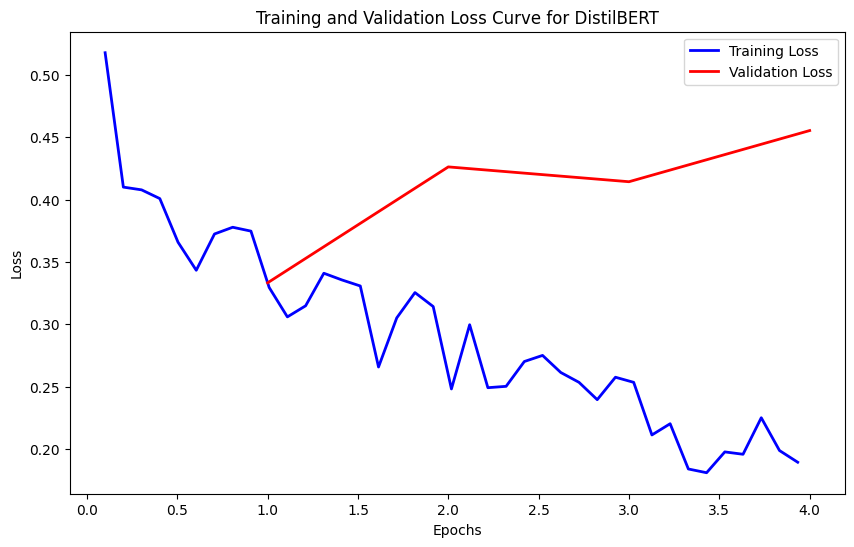

In [4]:
# Plot Training and Validation Loss Curve for DistilBERT
import matplotlib.pyplot as plt

# Assuming trainer.state contains loss information
training_loss = trainer.state.log_history

train_epochs = []
train_loss_values = []
eval_epochs = []
eval_loss_values = []

for log in training_loss:
    if 'loss' in log:
        train_epochs.append(log['epoch'])
        train_loss_values.append(log['loss'])
    elif 'eval_loss' in log:
        eval_epochs.append(log['epoch'])
        eval_loss_values.append(log['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss_values, label='Training Loss', color='blue', linewidth=2)
plt.plot(eval_epochs, eval_loss_values, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for DistilBERT')
plt.legend()
plt.show()

## ROC Curve for Logistic Regression Meta-Model

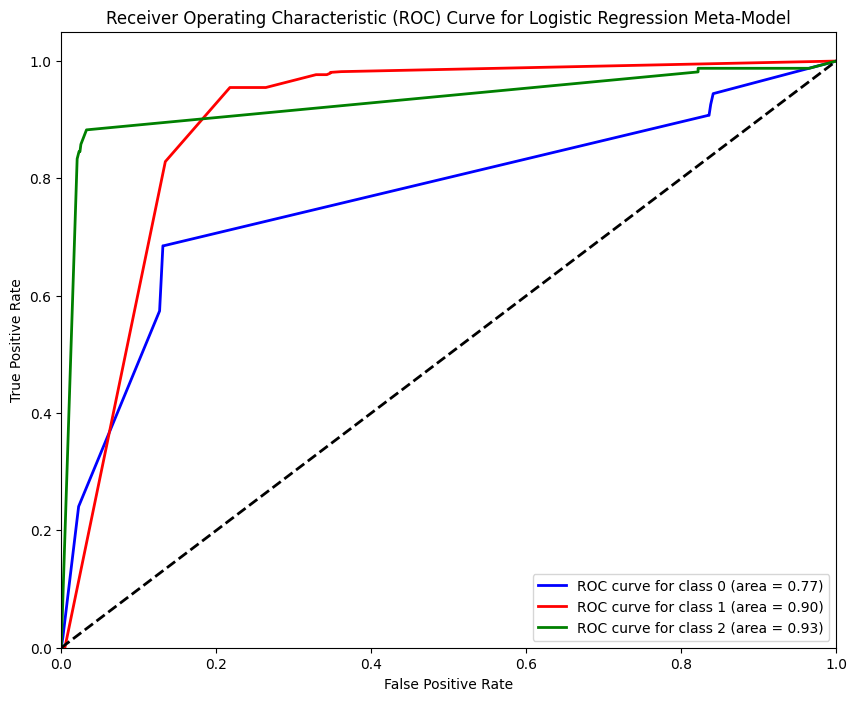

Logistic Regression Meta-Model ROC-AUC Score: 0.8662972606450353


In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for each class for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# ROC Curve for Logistic Regression Meta-Model
meta_preds_proba_lr = meta_model.predict_proba(X_test)

# Plotting the ROC curve for each class
fpr_lr = {}
tpr_lr = {}
roc_auc_lr = {}

for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], meta_preds_proba_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Plot all the ROC curves for Logistic Regression Meta-Model
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_lr[i], tpr_lr[i], color=color, lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc_lr[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression Meta-Model')
plt.legend(loc="lower right")
plt.show()

# ROC-AUC Score Calculation for Logistic Regression Meta-Model (overall)
meta_roc_auc_lr = roc_auc_score(y_test_bin, meta_preds_proba_lr, average='macro')
print(f"Logistic Regression Meta-Model ROC-AUC Score: {meta_roc_auc_lr}")

## Bar Chart to Compare Meta-Model Evaluation Metrics (Accuracy, Precision, Recall, F1 Score)

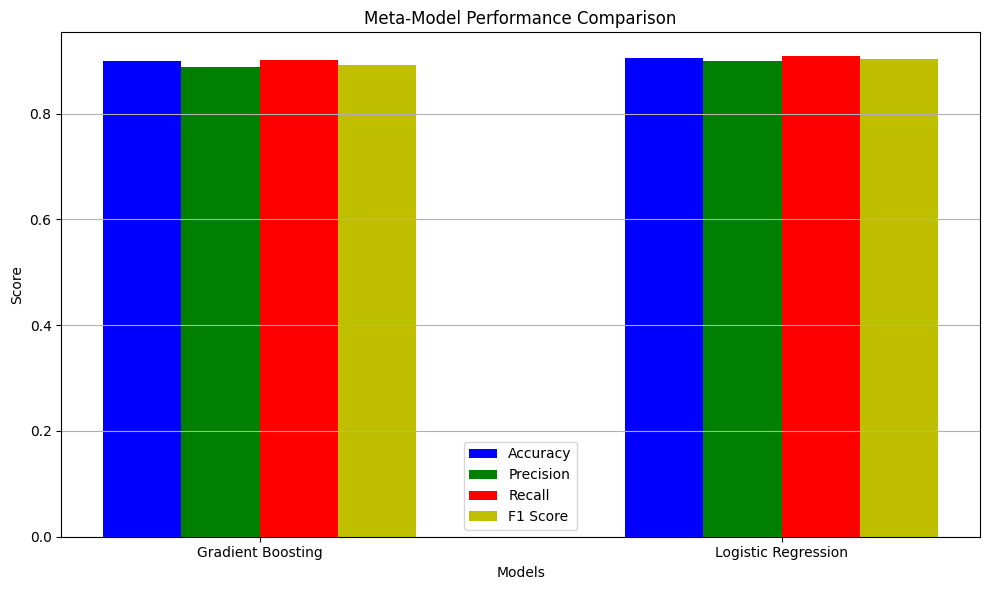

In [7]:
# Meta-Model Metrics
models = ['Gradient Boosting', 'Logistic Regression']
accuracies = [0.9002, 0.9042]
precisions = [0.8879, 0.8999]
recalls = [0.9007, 0.9082]
f1_scores = [0.8923, 0.9032]

x = np.arange(len(models))

width = 0.15  # Width of each bar
plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracies, width, label='Accuracy', color='b')
plt.bar(x, precisions, width, label='Precision', color='g')
plt.bar(x + width, recalls, width, label='Recall', color='r')
plt.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='y')

plt.xticks(x + width / 2, models)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Meta-Model Performance Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()